# DSCI 100 Group Project Report (Group 17)
## Classification of Mushrooms Using Multivariable KNN Classification

![Alt text](images/mushroom.png)
source: https://www.worldatlas.com/articles/8-most-poisonous-types-of-mushrooms.html

### Introduction

#### Background Information

$\;\;\;\;\;\;$From August through to November, mushrooms are a common sight to see in Canada. Be it deep in the forests of Quebec, or right in the backyard of your home in BC, mushrooms can be found everywhere. But although some may appear to be harmless, upon ingestion, many types of mushrooms may prove to cause various harmful symptoms to the human body. As a result, classification of mushrooms into either edible or poisonous is an extremely significant step for mushroom foragers around the globe. Using multivariable K- Nearest Neighbors classification of the dataset, our goal is to answer the following predictive question: **Are the factors of mushroom habitat, odor, gill colour, colour below stalk, and ring-type good predictors of mushroom edibility?** KNN classification is suitable for this problem because we desire to form a classifier using multiple characteristics of the mushrooms with a known class to predict if mushrooms without a class are either edible or poisonous for consumption, an example of binary classification.

In [3]:
library(tidyverse)
library(tidymodels)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [8]:
set.seed(87)
data <- read_csv("https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv") %>%
        mutate(class=as.factor(class))
# to check the proportion of edible and poisonous mushrooms in the database
dataprop <- data %>% 
            select(class) %>%
            group_by(class) %>%
            summarize(n=n()) %>%
            mutate(prop = (100*n)/sum(n))
         
dataprop_table <- knitr::kable(dataprop, caption = "Table 1: Proportion of Edible & Poisonous Mushrooms")
dataprop_table

Parsed with column specification:
cols(
  .default = col_character(),
  bruises = col_logical(),
  `gill-attachment` = col_logical()
)

See spec(...) for full column specifications.

Warning message:
“210 parsing failures.
 row             col           expected actual                                                                                     file
6039 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6041 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6376 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6425 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6435 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-1



Table: Table 1: Proportion of Edible & Poisonous Mushrooms

|class |    n|     prop|
|:-----|----:|--------:|
|e     | 4208| 51.79714|
|p     | 3916| 48.20286|

Warning message in warn_if_args_exist(list(...)):
“Extra arguments: 'cols' are being ignored.  If these are meant to be aesthetics, submit them using the 'mapping' variable within ggpairs with ggplot2::aes or ggplot2::aes_string.”


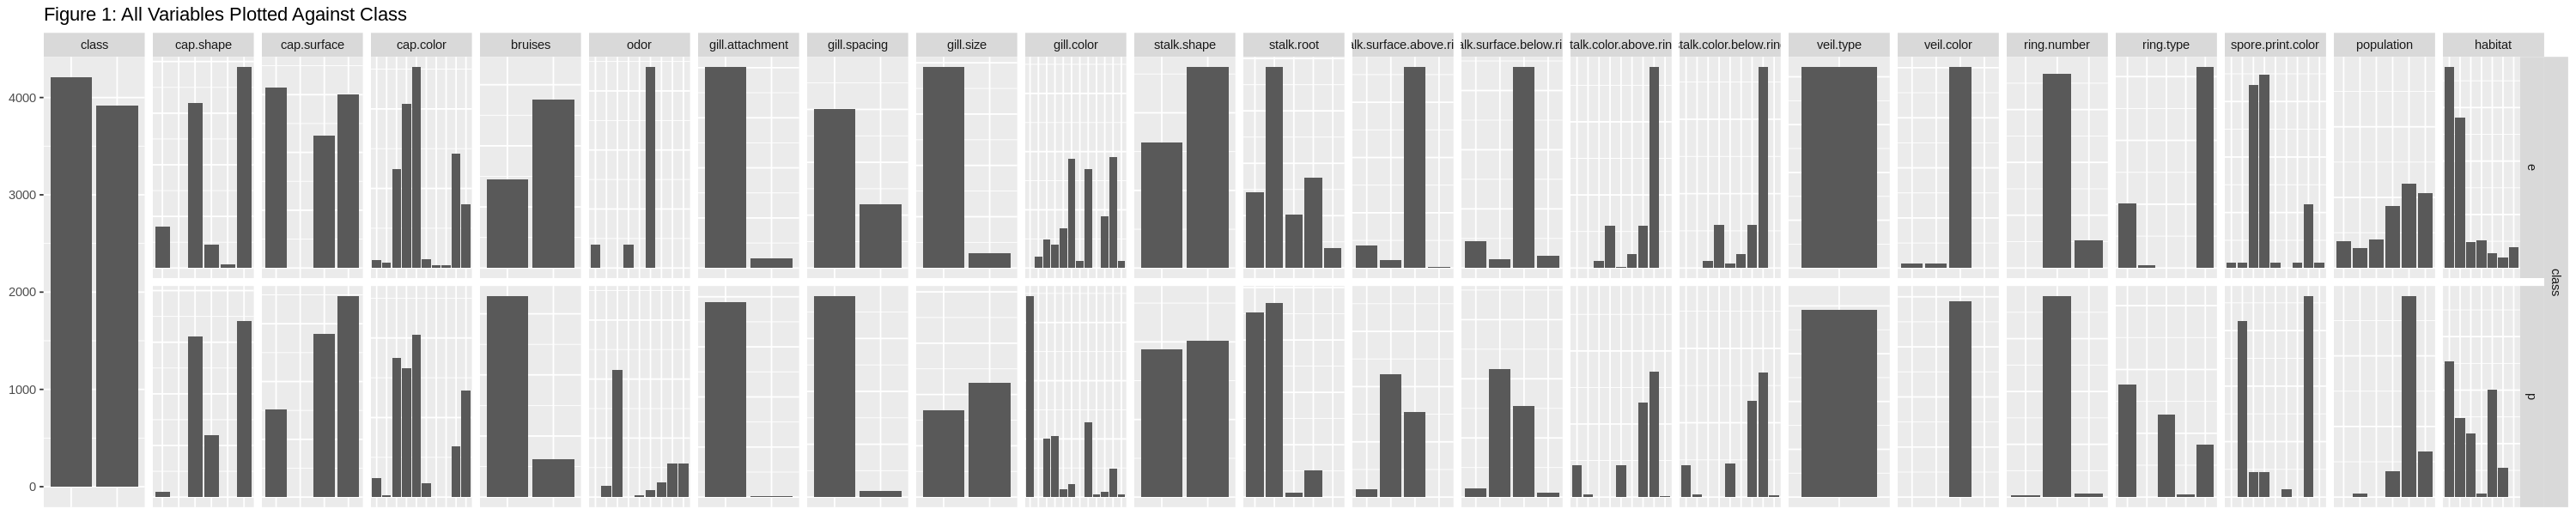

In [8]:
# to make the column names usable with ggplot and other commands, hyphens do not work
colnames(data) <- make.names(colnames(data))
filtered <- data %>% select(gill.color, ring.type, odor, stalk.color.below.ring, habitat, class)
# to make the column names usable with knn-classification
filtered$gill.color <- as.integer(as.factor(filtered$gill.color))
filtered$ring.type <- as.integer(as.factor(filtered$ring.type))
filtered$odor <- as.integer(as.factor(filtered$odor))
filtered$stalk.color.below.ring <- as.integer(as.factor(filtered$stalk.color.below.ring))
filtered$habitat <- as.integer(as.factor(filtered$habitat))
# splitting the database into training and testing datasets
split <- initial_split(filtered, prop = 0.75, Strata = class)
train <- training(split)
test <- testing(split)
options(repr.plot.width = 25, repr.plot.height = 5)
# to check for variables that have significant variability for poisonous and edible mushrooms
plot <- ggpairs(data, cols=1:23) +
    ggtitle("Figure 1: All Variables Plotted Against Class")
plot$plots = plot$plots[1:23]
plot$yAxisLabels = plot$yAxisLabels[1]
plot


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


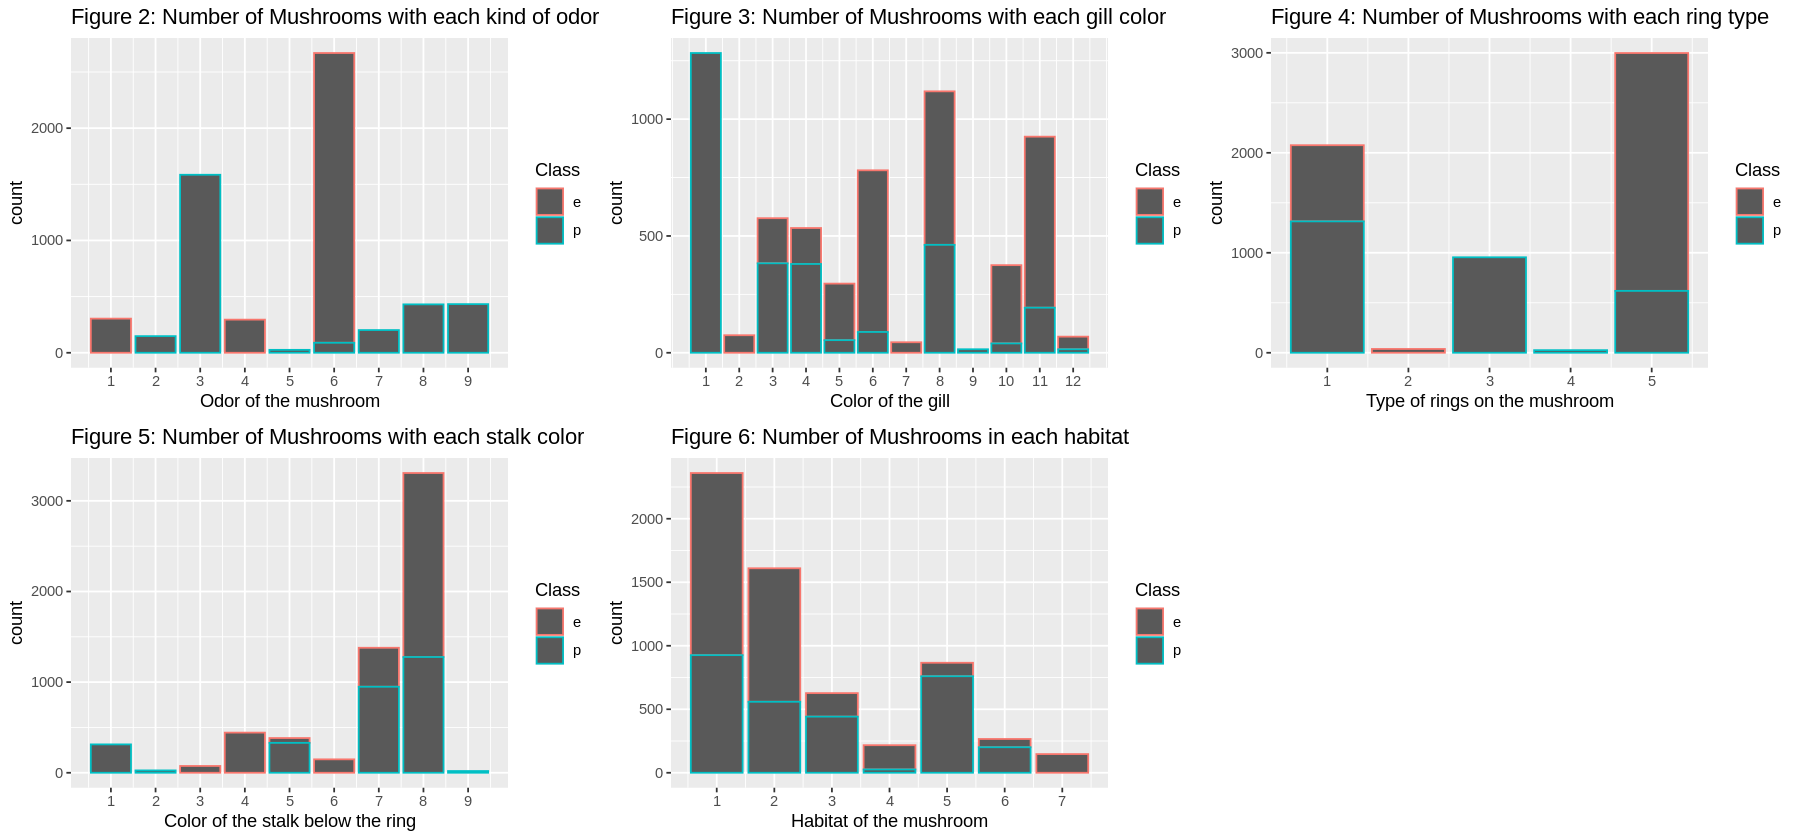

In [9]:
#to check the chosen variables variability with different classes
odor <- train %>% ggplot(aes(x=odor, color=class)) +
                    geom_histogram(stat="count") +
                    labs(x="Odor of the mushroom", color='Class') +
                    ggtitle("Figure 2: Number of Mushrooms with each kind of odor") +
                    scale_x_continuous(breaks = seq(1, 9, by = 1))
gill_color <- train %>% ggplot(aes(x=gill.color, color=class)) +
                        geom_histogram(stat="count") + 
                        labs(x="Color of the gill", color='Class') +
                        ggtitle("Figure 3: Number of Mushrooms with each gill color") +
                        scale_x_continuous(breaks = seq(1, 12, by = 1))
ring_type <- train %>% ggplot(aes(x=ring.type, color=class)) +
                        geom_histogram(stat="count") +
                        labs(x="Type of rings on the mushroom", color='Class') +
                        ggtitle("Figure 4: Number of Mushrooms with each ring type") +
                        scale_x_continuous(breaks = seq(1, 5, by = 1))
stalk_color_below_ring <- train %>% ggplot(aes(x=stalk.color.below.ring, color=class)) +
                                    geom_histogram(stat="count") +
                                    labs(x="Color of the stalk below the ring", color='Class') +
                                    ggtitle("Figure 5: Number of Mushrooms with each stalk color") +
                                    scale_x_continuous(breaks = seq(1, 9, by = 1))
habitat <- train %>% ggplot(aes(x=habitat, color=class)) +
                        geom_histogram(stat="count") +
                        labs(x="Habitat of the mushroom", color='Class') +
                        ggtitle("Figure 6: Number of Mushrooms in each habitat") +
                        scale_x_continuous(breaks = seq(1, 7, by = 1))
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(odor, gill_color, ring_type, stalk_color_below_ring, habitat)

In [22]:
# creating the workflow of the model
ms_recipe <- recipe(class ~ gill.color + ring.type + odor + habitat + stalk.color.below.ring, data = train)

ms_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# we use 10 vfolds and not a value as low as 5 for example, as the training set has ~6k rows and each fold would be too large otherwise
ms_vfold <- vfold_cv(train, v = 10, strata = class)
# we use a large range of values as the number of data points in the dataset are ~6k, so small values may not cover enough of the dataset
vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

ms_workflow <- workflow() %>%
  add_recipe(ms_recipe) %>%
  add_model(ms_spec) %>%
  tune_grid(resamples = ms_vfold, grid = vals)

#to check how accurate the model is for values of k, 1 to 30
accuracy <- ms_workflow %>%
            collect_metrics() %>%
            filter(.metric=="accuracy")

accuracy_table <- knitr::kable(accuracy, caption = "Table 2: Estimate Accuracy for K Values")
accuracy_table



Table: Table 2: Estimate Accuracy for K Values

| neighbors|.metric  |.estimator |      mean|  n|   std_err|.config |
|---------:|:--------|:----------|---------:|--:|---------:|:-------|
|         1|accuracy |binary     | 0.9757121| 10| 0.0024901|Model01 |
|         2|accuracy |binary     | 0.9757121| 10| 0.0024901|Model02 |
|         3|accuracy |binary     | 0.9757121| 10| 0.0024901|Model03 |
|         4|accuracy |binary     | 0.9757121| 10| 0.0024901|Model04 |
|         5|accuracy |binary     | 0.9757121| 10| 0.0024901|Model05 |
|         6|accuracy |binary     | 0.9757121| 10| 0.0024901|Model06 |
|         7|accuracy |binary     | 0.9757121| 10| 0.0024901|Model07 |
|         8|accuracy |binary     | 0.9757121| 10| 0.0024901|Model08 |
|         9|accuracy |binary     | 0.9755479| 10| 0.0024374|Model09 |
|        10|accuracy |binary     | 0.9755479| 10| 0.0024374|Model10 |
|        11|accuracy |binary     | 0.9750548| 10| 0.0025274|Model11 |
|        12|accuracy |binary     | 0.975

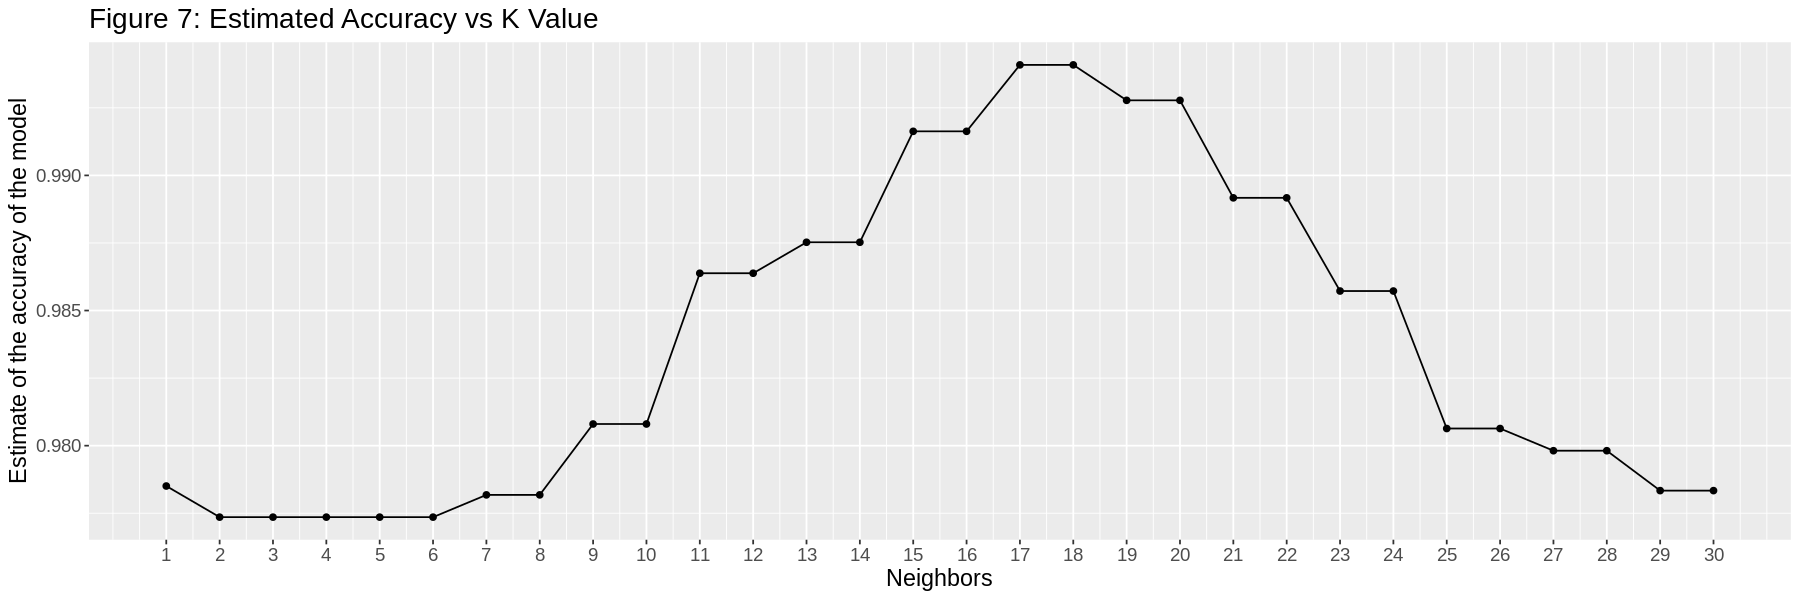

In [10]:
#to find which value of k results in the more accurate model
options(repr.plot.width = 15, repr.plot.height = 5)
compare_k_acc <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Estimate of the accuracy of the model") + 
  ggtitle("Figure 7: Estimated Accuracy vs K Value") +
  theme(text = element_text(size = 14)) +
  scale_x_continuous(breaks = seq(1, 30, by = 1))
compare_k_acc

In [28]:
#hence, we have the k that would result in the more accurate model, k=17
ms_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) %>%
  set_engine("kknn") %>%
  set_mode("classification")

ms_final_workflow <- workflow() %>%
  add_recipe(ms_recipe) %>%
  add_model(ms_final_spec) %>%
  fit(data = train)

#to test accuracy of the model against the testing set
ms_predictions <- predict(ms_final_workflow, test) %>%
  bind_cols(test) %>%
  mutate(class=as.factor(class))
ms_predict_test <- ms_predictions %>%
                   metrics(truth = class, estimate = .pred_class) %>%
                   filter(.metric == "accuracy")

ms_predict_test_table <- knitr::kable(ms_predict_test, caption = "Table 3: Prediction Accuracy")
ms_predict_test_table

#confusion matrix to see how many classifications the model did not get right in the testing set
confmat <- conf_mat(ms_predictions, truth = class, estimate = .pred_class)
confmat



Table: Table 3: Prediction Accuracy

|.metric  |.estimator | .estimate|
|:--------|:----------|---------:|
|accuracy |binary     | 0.9832595|

          Truth
Prediction    e    p
         e 1006   11
         p   23  991

### Methodology & Results

$\;\;\;\;\;\;$Our project goal is to build a predictive model, using the K-Nearest Neighbors Classification algorithm, to determine if a mushroom is edible or poisonous. To do so, we used gill color, ring type, odor the habitat, and the color of the stalk below the ring to compute the distance between unseen data points and the K-closest data points. Once we have identified the closest neighbors, we can assign the label that appears the most often in the set of K neighbors to the unseen data point. This algorithm is appropriate for our question because often, mushrooms with similar attributes can be similarly classified as either edible or poisonous. 

$\;\;\;\;\;\;$We chose to drop some of the attributes from the data set because some of them are very similar to each other, and we wanted to lower the computational time and reduce unnecessary complexity of the algorithm. 

$\;\;\;\;\;\;$The first step of our data analysis process was to set the seed value in order to allow R to split our data in a manner that did not introduce human influence on the evaluation, but still allow reproducibility of our analysis by others.

$\;\;\;\;\;\;$Next, we checked to see that the two possible predicted classes (edible or poisonous) were somewhat equally represented within the mushroom dataset (ie. imbalance would not present to be an issue in our evaluation). We found that within the entire dataset, about 52% of the mushrooms were known to be edible and 48% known to be poisonous. Since this fraction is close to a 50-50 split, we can conclude that imbalance will not negatively impact the results of our data analysis.

$\;\;\;\;\;\;$The next step we took to wrangle our dataset was to convert the observations from characters into factors, then from factors into integers. This was done so that each variable was on a numeric scale, which allows the distance between points, which is a necessary step in KNN, to be calculated. 

$\;\;\;\;\;\;$For the initial split of our dataset, we split our data so that 75% was in the training set and 25% was in the testing set. We intuitively chose this because we felt that it was a good ratio in which the model would not be underfitted or overfit, while still leaving enough data remaining to use when testing our model. Additionally, it was mentioned in textbook section 6.5.1 that generally the amount of data that goes in the training set is between 50% and  95%, so as a result, we felt that 75% was a good midpoint between these values. 

$\;\;\;\;\;\;$In order to work towards finding an answer to our question, we used the ggpairs function to visualize how strongly impacted the predictor outcome is by the different explanatory variables. From these results we decided to use 5 out of the original 22 possible attributes, of which we observed had the greatest impact on the edibility of mushrooms, signified by larger differences between edible/poisonous counts depending on the different variables. These 5 were shown visually in the form of separate histograms to get a clearer picture of the significance of these variables to be used in making the classifier.

$\;\;\;\;\;\;$To construct the classifier able of creating new predictions on mushrooms with consumption effects unknown to us we used the straight-line distance of the KNN algorithm (specified as “rectangular” in the sequence of code used to build the classifier).  This classifier is built involving the training set of the mushroom data, and the 5 chosen explanatory variables.

$\;\;\;\;\;\;$The subsequent steps were taken in an effort to assess the accuracy of the classifier we built, and to tune the classifier to maximize the overall prediction accuracy. In the context of our data analysis problem, accuracy is important because the misclassification of a poisonous mushroom as an edible one would likely have major negative repercussions for the unfortunate person who used the mushroom as an ingredient in their dinner that night. To begin, created a workflow and used the method of cross-validation to find the accuracy values for a range of K values. After creating a scatter plot of accuracy vs KNN value (seen in Figure 7), it was found that the ideal K value that yields the classifier with the highest prediction accuracy is when K = 17 or K = 18, with a resultant accuracy of approximately 99.4%. We then tested the accuracy of our classifier by allowing it to make predictions on the testing set of data we put aside at the beginning of our analysis and assessed the accuracy using the metrics function. Lastly, we used a confusion matrix in order to see the predicted labels and the correct labels of the predictions made on the testing set of data.

#### Results

$\;\;\;\;\;\;$As we can see from Figure 7, our model had a training accuracy of approximately 99.4% with both K = 17 and K = 18, and had an overall testing accuracy of  Additionally, our model has a precision value of 100%, since it does not falsely classify poisonous mushrooms as edible, and an error rate of just 1.03%, as it incorrectly labeled 21 edible mushrooms out of a total 2031 observations. 

### Discussion

$\;\;\;\;\;\;$All the metrics of our model were higher than initially expected, which led us to believe that it was over fitting to the testing set. However, since the model also had high accuracy and precision on the testing set this is not a large concern. As seen in Figures 2-6, our model was able to work as well as it did because for each of our attributes their distribution between the values was fairly discrete, meaning that, for the most part, if an attribute’s value had observations for both edible and poisonous, one would always dominate (taking up much more than 50% of recorded observations). 

$\;\;\;\;\;\;$We can apply our classification model to any number of unknown mushrooms and expect to have similar results, however the model would have to be readjusted if we are trying to classify mushrooms with different attributes, or ones with missing values. Additionally, we could try several different models using different combinations of attributes to attempt to improve our model, or to compare the importance of specific attributes, although this is unlikely to improve our model since our accuracy is already almost at 100%. 

$\;\;\;\;\;\;$Our findings have the potential to help keep a person who desires to forage for wild mushrooms safe from gathering and consuming any ones that are poisonous upon close inspection of the observable characteristics of the mushroom. Our classifier for example, could be presented in the form of a mobile app to be easily accessible and user-friendly.

$\;\;\;\;\;\;$Some possible related predictive questions that our model and analysis could lead to are if the characteristics of mushrooms could be used to predict its nutritional value of certain macromolecules and vitamins? And can mushrooms be classified by their attributes to predict what regions of the world they naturally occur in (this would require a larger dataset than what was used in our analysis of mushroom edibility)?


***
## Appendix

#### Bibliography

* *Mushroom Toxicity* - statpearls - NCBI bookshelf. (n.d.). Retrieved April 4, 2022, from https://www.ncbi.nlm.nih.gov/books/NBK537111/

* Timbers, T.-A., Campbell, T., & Lee, M. (2022). *Data science: An introduction.* CRC Press.

* UCI Machine Learning. (2016, December 1). *Mushroom classification.* Kaggle. Retrieved April 1, 2022, from https://www.kaggle.com/datasets/uciml/mushroom-classification 

* Zolis, S. (2014, October 15). *A guide to mushroom foraging in Canada.* Canadian Living. Retrieved April 2, 2022, from https://www.canadianliving.com/life-and-relationships/culture-and-entertainment/article/a-guide-to-mushroom-foraging-in-canada


<font color=gray>Group 17 members: Alex Caceres-Wright, Alyanna Llavore and Abdul Faiz</font>